In [1]:
# Gerekli kütüphanelerin kurulmasi
import pandas as pd

import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

'en_US.UTF-8'

In [2]:
df_cleaned_raw = pd.read_csv("cleaned_raw_data.csv")


/tmp/ipython-input-3159120274.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cleaned_raw = pd.read_csv("cleaned_raw_data.csv")


In [3]:
df_cleaned_raw.head(3)

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,category,InvoiceDateOnly,Year,...,DayOfWeekName,MonthName,Season,IsReturn,TotalPrice,CustomerIDInvoiceNo,Description_filled,IsSuspiciousReturn,is_holiday,QuantityType
0,536847,21231,24,2010-12-03 09:31:00,1.25,17135,United Kingdom,Decor & Gifts,2010-12-03,2010,...,Friday,December,Winter,False,30.0,17135.0_536847,SWEETHEART CERAMIC TRINKET BOX,False,False,Sale (Positive)
1,536847,22067,24,2010-12-03 09:31:00,1.65,17135,United Kingdom,Garden & Outdoor,2010-12-03,2010,...,Friday,December,Winter,False,39.6,17135.0_536847,CHOC TRUFFLE GOLD TRINKET POT,False,False,Sale (Positive)
2,536847,22161,24,2010-12-03 09:31:00,0.65,17135,United Kingdom,Decor & Gifts,2010-12-03,2010,...,Friday,December,Winter,False,15.6,17135.0_536847,HEART DECORATION RUSTIC HANGING,False,False,Sale (Positive)


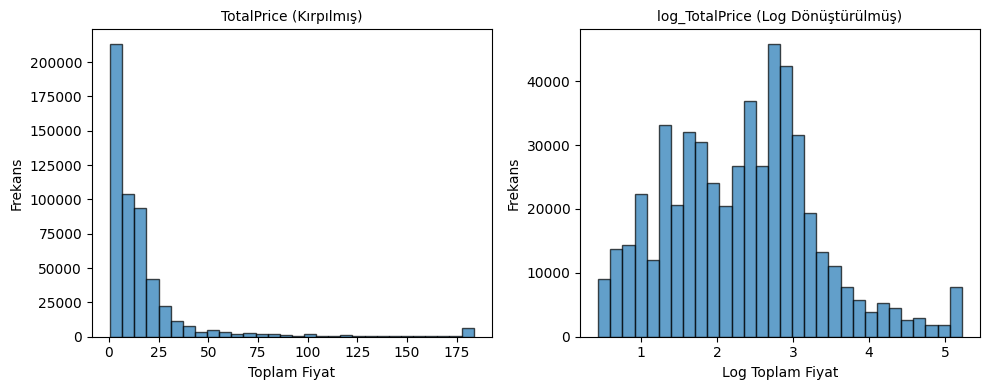

CLV modellemesine hazır müşteri sayısı: 2846
              recency          T  frequency  monetary  monetary_avg
CustomerID                                                         
12347       52.142857  52.285714          7   4244.00    606.285714
12348       40.285714  51.000000          4   1740.84    435.210000
12352       37.142857  42.285714          8   2216.54    277.067500
12356       43.142857  46.428571          3   2671.03    890.343333
12358       21.285714  21.428571          2   1168.06    584.030000


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =====================================================
# 1️⃣ Veri Temizliği: CLV analizine uygun hale getirme
# =====================================================

df_clv = df_cleaned_raw.copy()

# 1. Tarih sütununu datetime tipine çevir
df_clv["InvoiceDate"] = pd.to_datetime(df_clv["InvoiceDate"], errors="coerce")

# 2. CustomerID'si olmayanları çıkar (CLV müşteri bazlı analizdir)
df_clv = df_clv.dropna(subset=["CustomerID"])

# 3. İade veya şüpheli iade kayıtlarını çıkar
df_clv = df_clv[(df_clv["IsReturn"] == False) & (df_clv["IsSuspiciousReturn"] == False)]

# 4. Negatif veya sıfır fiyat/miktar değerlerini çıkar
df_clv = df_clv[(df_clv["Quantity"] > 0) & (df_clv["UnitPrice"] > 0)]

# =====================================================
# 2️⃣ Toplam satış tutarı kontrolü
# =====================================================
if "TotalPrice" not in df_clv.columns:
    df_clv["TotalPrice"] = df_clv["Quantity"] * df_clv["UnitPrice"]

# =====================================================
# 3️⃣ Aykırı değerleri kırp (uç değerlerin etkisini azaltmak için)
# =====================================================
def cap_outliers(series, lower_quantile=0.01, upper_quantile=0.99):
    """Verilen serideki uç değerleri alt ve üst yüzde aralıklarına kırpar."""
    q_low = series.quantile(lower_quantile)
    q_high = series.quantile(upper_quantile)
    return np.clip(series, q_low, q_high)

df_clv["UnitPrice"] = cap_outliers(df_clv["UnitPrice"])
df_clv["TotalPrice"] = cap_outliers(df_clv["TotalPrice"])

# =====================================================
# 4️⃣ Log dönüşümü (çarpıklığı azaltır)
# =====================================================
df_clv["log_UnitPrice"] = np.log1p(df_clv["UnitPrice"])
df_clv["log_TotalPrice"] = np.log1p(df_clv["TotalPrice"])

# =====================================================
# 5️⃣ CLV modeline uygun müşteri bazlı özet tablo
# =====================================================
# Tarihler artık datetime olduğu için fark alınabilir
clv_summary = df_clv.groupby("CustomerID").agg({
    "InvoiceDate": [
        lambda x: (x.max() - x.min()).days,                         # recency
        lambda x: (df_clv["InvoiceDate"].max() - x.min()).days      # T (müşteri yaşı)
    ],
    "InvoiceNo": "nunique",     # frequency
    "TotalPrice": "sum"         # monetary
})

# Çoklu sütun isimlerini düzleştir
clv_summary.columns = ["recency", "T", "frequency", "monetary"]

# =====================================================
# 6️⃣ Model varsayımlarına uygun filtreleme
# =====================================================
clv_summary = clv_summary[clv_summary["frequency"] > 1]
clv_summary["monetary_avg"] = clv_summary["monetary"] / clv_summary["frequency"]

# =====================================================
# 7️⃣ Zaman değişkenlerini haftaya çevir
# =====================================================
clv_summary["recency"] = clv_summary["recency"] / 7
clv_summary["T"] = clv_summary["T"] / 7

# =====================================================
# 8️⃣ Görsel kontrol
# =====================================================
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(df_clv["TotalPrice"], bins=30, edgecolor="k", alpha=0.7)
plt.title("TotalPrice (Kırpılmış)", fontsize=10)
plt.xlabel("Toplam Fiyat")
plt.ylabel("Frekans")

plt.subplot(1, 2, 2)
plt.hist(df_clv["log_TotalPrice"], bins=30, edgecolor="k", alpha=0.7)
plt.title("log_TotalPrice (Log Dönüştürülmüş)", fontsize=10)
plt.xlabel("Log Toplam Fiyat")
plt.ylabel("Frekans")

plt.tight_layout()
plt.show()

# =====================================================
# 9️⃣ Sonuç
# =====================================================
print("CLV modellemesine hazır müşteri sayısı:", clv_summary.shape[0])
print(clv_summary.head())


# Degiskenlerin Dagilimlari

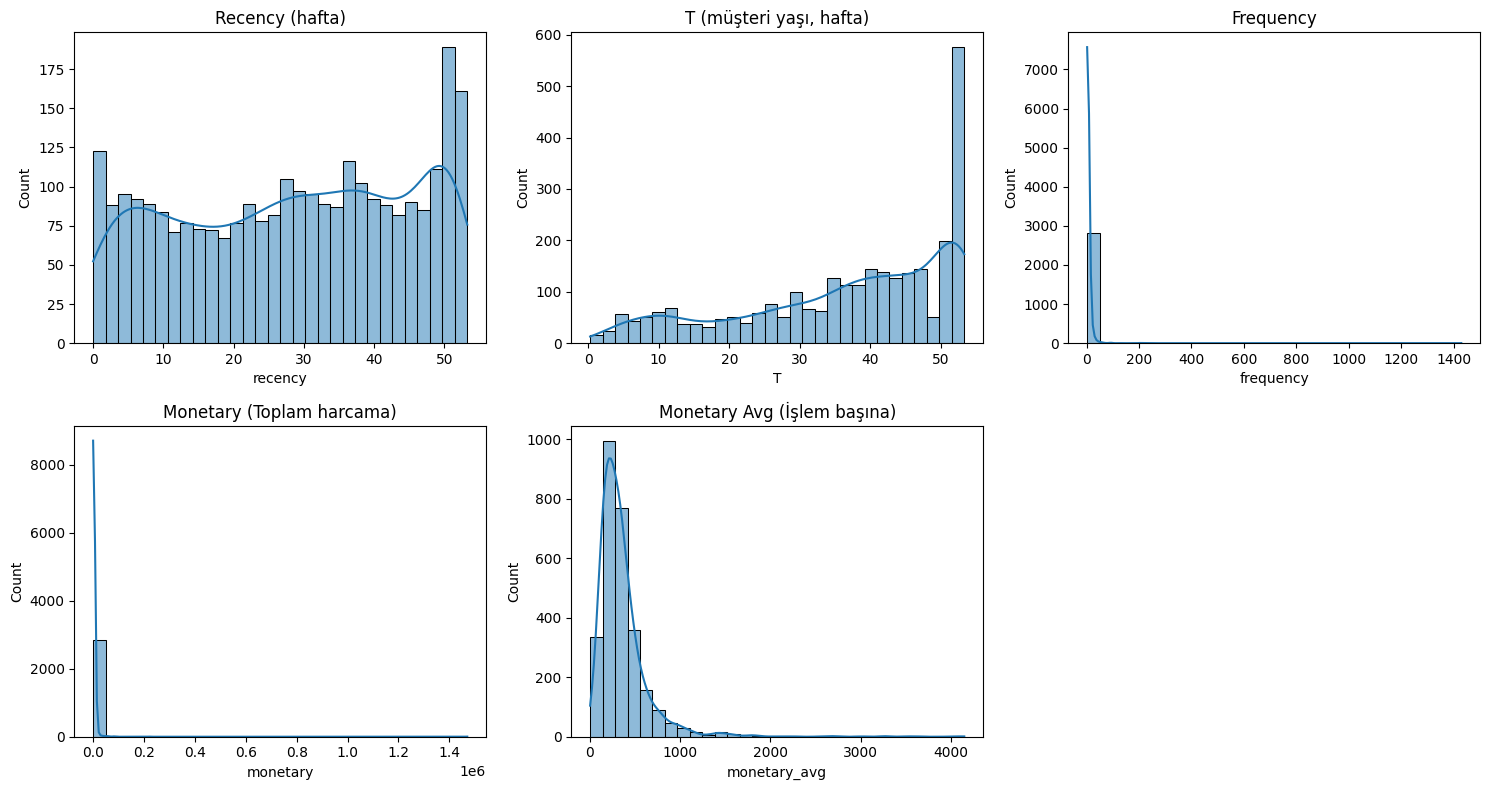

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(15,8))

sns.histplot(clv_summary["recency"], bins=30, kde=True, ax=axes[0,0])
axes[0,0].set_title("Recency (hafta)")

sns.histplot(clv_summary["T"], bins=30, kde=True, ax=axes[0,1])
axes[0,1].set_title("T (müşteri yaşı, hafta)")

sns.histplot(clv_summary["frequency"], bins=30, kde=True, ax=axes[0,2])
axes[0,2].set_title("Frequency")

sns.histplot(clv_summary["monetary"], bins=30, kde=True, ax=axes[1,0])
axes[1,0].set_title("Monetary (Toplam harcama)")

sns.histplot(clv_summary["monetary_avg"], bins=30, kde=True, ax=axes[1,1])
axes[1,1].set_title("Monetary Avg (İşlem başına)")

axes[1,2].axis("off")  # boş bırak

plt.tight_layout()
plt.show()


Dağılımlar sağa çarpık ve özellikle frequency, monetary ve monetary_avg değişkenlerinde uzun kuyruklar var. Bu tip dağılımlarda dikkat edilmesi gerekenler :

Recency ve T

recency dağılımı nispeten dengeli ama T (müşteri yaşı) dağılımı bazı müşteriler için çok uzun süreli görünüyor.

Bu, bazı müşterilerin sistemde uzun süre olmasına rağmen az işlem yaptığı anlamına gelebilir.

BG/NBD modeli bu tip heterojenliği hesaba katar.

Frequency

Çoğu müşteri az sayıda işlem yapmış (1–5 arası) ama birkaç müşteri çok sık alışveriş yapmış → uç değerler.

Bu durumda BG/NBD modeline uygun: model uç değerleri doğal olarak dikkate alabilir ama çok ekstrem değerleri kırpmak istersek üst %1 veya %0.5 kesebiliriz.

Monetary ve Monetary_avg

Bu değişkenler ciddi şekilde sağa çarpık.

monetary_avg özellikle birkaç işlem başına çok yüksek harcama yapan müşteriler içeriyor.

Gamma-Gamma modelinde log-transform yapmamiza gerek yok, çünkü model sağa çarpık harcamaları direkt işleyebilir, ama uç değerler çok ekstremse yine de kirpilabilir ama yapmayacagim.

In [6]:
%pip install lifetimes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 10.2 MB/s eta 0:00:00


1️⃣ Ortalama CLV (£42,105)

Bu, tüm müşterilerin ortalama olarak önümüzdeki 12 ayda getireceği beklenen satış değeridir.

Yani tipik bir müşteri yaklaşık 42 bin £ değerinde alışveriş yapacak demektir.

Ortalama, aşırı yüksek CLV’ye sahip VIP müşterilerden dolayı biraz yukarı çekilmiş olabilir (outlier etkisi).

2️⃣ Medyan CLV (£28,712)

Medyan, müşterileri CLV’ye göre sıraladığımızda tam ortadaki müşterinin CLV’sidir.

Yani yarısı 28,712 £ altında, diğer yarısı üstünde satış getirecek.

Ortalama ile medyan farkı büyük → CLV dağılımı sağa çarpık, yani bazı müşteriler çok yüksek değer getiriyor (VIP’ler).

3️⃣ Maksimum CLV (£2,522,492)

Bu, en değerli müşterinin önümüzdeki 12 ayda getireceği beklenen satış.

Tek bir müşteri tüm ortalama müşterilerin onlarca katı değerinde satış sağlıyor.

Bu müşteri, stratejik olarak çok önemli ve kaybedilmemesi gerekir.

4️⃣ Toplam CLV (£119,788,589)

Tüm 2,845 müşterinin 12 ayda şirkete getireceği toplam beklenen satış.

Pazarlama, stok, bütçe ve gelir planlaması için önemli bir öngörü sağlar.

📌 Özet Yorum

Müşteri değerleri heterojen → çoğu müşteri ortalama veya düşük CLV, ama birkaç VIP müşteri toplam satışın büyük kısmını oluşturuyor.

Stratejik öncelik:

VIP ve High segmentini korumak → toplam gelir için kritik

Medium ve Low segmentini artırmak veya elde tutmak → uzun vadede büyüme potansiyeli

In [7]:
df_clv.to_csv('data_for_clv_analysis.csv', index=False, encoding="utf-8-sig", quoting=1) # clv analizi icin data



In [8]:
df_cleaned_raw.to_csv('data_for_general_analysis.csv', index=False, encoding="utf-8-sig", quoting=1)

In [9]:
df_clv.head(3)



,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,category,InvoiceDateOnly,Year,...,Season,IsReturn,TotalPrice,CustomerIDInvoiceNo,Description_filled,IsSuspiciousReturn,is_holiday,QuantityType,log_UnitPrice,log_TotalPrice
0,536847,21231,24,2010-12-03 09:31:00,1.25,17135,United Kingdom,Decor & Gifts,2010-12-03,2010,...,Winter,False,30.0,17135.0_536847,SWEETHEART CERAMIC TRINKET BOX,False,False,Sale (Positive),0.810930,3.433987
1,536847,22067,24,2010-12-03 09:31:00,1.65,17135,United Kingdom,Garden & Outdoor,2010-12-03,2010,...,Winter,False,39.6,17135.0_536847,CHOC TRUFFLE GOLD TRINKET POT,False,False,Sale (Positive),0.974560,3.703768
2,536847,22161,24,2010-12-03 09:31:00,0.65,17135,United Kingdom,Decor & Gifts,2010-12-03,2010,...,Winter,False,15.6,17135.0_536847,HEART DECORATION RUSTIC HANGING,False,False,Sale (Positive),0.500775,2.809403


In [10]:
df_cleaned_raw.head(3)

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,category,InvoiceDateOnly,Year,...,DayOfWeekName,MonthName,Season,IsReturn,TotalPrice,CustomerIDInvoiceNo,Description_filled,IsSuspiciousReturn,is_holiday,QuantityType
0,536847,21231,24,2010-12-03 09:31:00,1.25,17135,United Kingdom,Decor & Gifts,2010-12-03,2010,...,Friday,December,Winter,False,30.0,17135.0_536847,SWEETHEART CERAMIC TRINKET BOX,False,False,Sale (Positive)
1,536847,22067,24,2010-12-03 09:31:00,1.65,17135,United Kingdom,Garden & Outdoor,2010-12-03,2010,...,Friday,December,Winter,False,39.6,17135.0_536847,CHOC TRUFFLE GOLD TRINKET POT,False,False,Sale (Positive)
2,536847,22161,24,2010-12-03 09:31:00,0.65,17135,United Kingdom,Decor & Gifts,2010-12-03,2010,...,Friday,December,Winter,False,15.6,17135.0_536847,HEART DECORATION RUSTIC HANGING,False,False,Sale (Positive)


In [11]:
clv_summary.head(3)

,recency,T,frequency,monetary,monetary_avg
CustomerID,,,,,
12347,52.142857,52.285714,7,4244.00,606.285714
12348,40.285714,51.000000,4,1740.84,435.210000
12352,37.142857,42.285714,8,2216.54,277.067500


In [12]:
!pip install lifetimes --quiet
import pandas as pd
from lifetimes import BetaGeoFitter, GammaGammaFitter


In [13]:
# 🚀 KOMPLE CLV TAHMİN VE İŞ ANALİZİ SİSTEMİ
import pandas as pd
import numpy as np
from lifetimes import BetaGeoFitter, GammaGammaFitter
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("🎯 CLV TAHMİN VE İŞ DEĞERİ ANALİZ SİSTEMİ")
print("="*80)

# ==========================================
# BÖLÜM 1: RFM & CLV HESAPLAMA
# ==========================================
print("\n📊 BÖLÜM 1: RFM VERİSİ VE CLV HESAPLAMA")
print("-"*80)

rfm = clv_summary.reset_index()
rfm = rfm[['CustomerID', 'frequency', 'recency', 'T', 'monetary_avg']]
rfm = rfm[rfm['frequency'] > 1].copy()
print(f"✅ RFM Veri Seti: {len(rfm)} müşteri")

# BG/NBD + Gamma-Gamma Modelleri
print("\n🔄 BG/NBD ve Gamma-Gamma modelleri eğitiliyor...")
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(rfm['frequency'], rfm['recency'], rfm['T'])

ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(rfm['frequency'], rfm['monetary_avg'])

# CLV hesaplama
time_periods = [3, 6, 12]
for t in time_periods:
    rfm[f'clv_{t}m'] = ggf.customer_lifetime_value(
        bgf, rfm['frequency'], rfm['recency'], rfm['T'], rfm['monetary_avg'],
        time=t, freq='M', discount_rate=0.01
    )

rfm['prob_alive'] = bgf.conditional_probability_alive(rfm['frequency'], rfm['recency'], rfm['T'])
rfm['expected_purchases_3m'] = bgf.predict(3, rfm['frequency'], rfm['recency'], rfm['T'])
print("✅ CLV hesaplamaları tamamlandı")

# ==========================================
# BÖLÜM 2: FEATURE ENGINEERING
# ==========================================
print("\n🔧 BÖLÜM 2: FEATURE ENGINEERING")
print("-"*80)

df_ml = df_cleaned_raw.copy()
df_ml['InvoiceDateOnly'] = pd.to_datetime(df_ml['InvoiceDateOnly'])
df_ml['day_of_week'] = df_ml['InvoiceDateOnly'].dt.dayofweek
df_ml['is_weekend'] = df_ml['day_of_week'].isin([5, 6]).astype(int)

df_feat = df_ml.groupby('CustomerID').agg(
    frequency=('InvoiceNo', 'nunique'),
    total_items=('Quantity', 'sum'),
    avg_items_per_order=('Quantity', 'mean'),
    max_items=('Quantity', 'max'),
    monetary_sum=('TotalPrice', 'sum'),
    monetary_avg=('TotalPrice', 'mean'),
    monetary_max=('TotalPrice', 'max'),
    monetary_min=('TotalPrice', 'min'),
    monetary_std=('TotalPrice', 'std'),
    unique_products=('StockCode', 'nunique'),
    unique_categories=('category', 'nunique'),
    unique_countries=('Country', 'nunique'),
    total_returns=('IsReturn', 'sum'),
    weekend_ratio=('is_weekend', 'mean'),
    first_purchase=('InvoiceDateOnly', 'min'),
    last_purchase=('InvoiceDateOnly', 'max'),
    purchase_days=('InvoiceDateOnly', lambda x: x.dt.date.nunique())
).reset_index()

# Türetilmiş özellikler
reference_date = df_ml['InvoiceDateOnly'].max()  # Veri setindeki en son satın alma tarihi referans alınır
df_feat['recency'] = (reference_date - df_feat['last_purchase']).dt.days # # Müşterinin son alışverişinden beri geçen gün
df_feat['customer_age_days'] = (df_feat['last_purchase'] - df_feat['first_purchase']).dt.days  # # Müşterinin aktif olduğu toplam gün
df_feat['customer_age_days'] = df_feat['customer_age_days'].replace(0, 1)                     #  # 0 gün hatasını önlemek için minimum 1 gün atanır
df_feat['purchase_frequency'] = df_feat['frequency'] / (df_feat['customer_age_days'] / 30 + 1)    #  # Aylık satın alma sıklığı
df_feat['avg_days_between_purchases'] = df_feat['customer_age_days'] / (df_feat['frequency'] + 1) #  # Siparişler arasındaki ortalama gün
df_feat['items_per_day'] = df_feat['total_items'] / (df_feat['customer_age_days'] + 1)  # # Günlük ortalama ürün adedi
df_feat['avg_order_value'] = df_feat['monetary_sum'] / df_feat['frequency']             # # Ortalama sipariş değeri (AOV)
df_feat['monetary_cv'] = df_feat['monetary_std'] / (df_feat['monetary_avg'] + 1)        # # Harcama tutarlarının değişkenlik katsayısı
df_feat['return_rate'] = df_feat['total_returns'] / df_feat['frequency']                # Sipariş başına iade oranı
df_feat['is_high_value'] = (df_feat['monetary_sum'] > df_feat['monetary_sum'].quantile(0.75)).astype(int)   # # En çok harcayan üst %25 müşteri
df_feat['is_frequent'] = (df_feat['frequency'] > df_feat['frequency'].quantile(0.75)).astype(int) # # En sık alışveriş yapan üst %25 müşteri
df_feat['is_recent'] = (df_feat['recency'] < df_feat['recency'].quantile(0.25)).astype(int) # En yeni alışveriş yapan alt %25 müşteri
df_feat['engagement_score'] = (
    df_feat['purchase_frequency'] * 0.4 + # # Düzenli alışveriş yapan müşteriye daha yüksek skor
    df_feat['unique_categories'] * 0.3 +  # # Çeşitli kategorilerden alışveriş yapan müşteriye skor
    (1 / (df_feat['recency'] + 1)) * 100 * 0.3 # # Yakın zamanda alışveriş yapan müşteriye skor
)

df_feat = df_feat.drop(['first_purchase', 'last_purchase'], axis=1)
df_feat = df_feat.replace([np.inf, -np.inf], np.nan)
numeric_cols = df_feat.select_dtypes(include=[np.number]).columns
df_feat[numeric_cols] = df_feat[numeric_cols].fillna(df_feat[numeric_cols].median())
print(f"✅ {len(df_feat.columns)-1} özellik oluşturuldu")

# ==========================================
# BÖLÜM 3: MODEL EĞİTİMİ
# ==========================================
print("\n🤖 BÖLÜM 3: MACHINE LEARNING MODELİ")
print("-"*80)

y = rfm.set_index('CustomerID')['clv_6m'].reindex(df_feat['CustomerID']).fillna(0)
df_feat = df_feat.reset_index(drop=True)
y = y.reset_index(drop=True)

# Outlier temizleme
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1
mask = (y >= Q1 - 1.5 * IQR) & (y <= Q3 + 1.5 * IQR)
df_feat_clean = df_feat[mask].reset_index(drop=True)
y_clean = y[mask].reset_index(drop=True)
print(f"✅ Outlier temizlendi: {len(df_feat)} -> {len(df_feat_clean)} müşteri")

X = df_feat_clean.drop('CustomerID', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y_clean, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

xgb_model = xgb.XGBRegressor(
    n_estimators=200, max_depth=5, learning_rate=0.05, subsample=0.8,
    colsample_bytree=0.8, min_child_weight=3, gamma=0.1,
    reg_alpha=0.1, reg_lambda=1.0, random_state=42, tree_method='hist', n_jobs=-1
)

xgb_model.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], verbose=False)
y_pred_train = xgb_model.predict(X_train_scaled)
y_pred_test = xgb_model.predict(X_test_scaled)

# Metrikler
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)
cv_scores = cross_val_score(xgb_model, X_train_scaled, y_train, cv=5, scoring='r2', n_jobs=-1)

print(f"\n📊 MODEL PERFORMANSI:")
print(f"   Test R² Score: {test_r2:.4f}")
print(f"   Test RMSE: {test_rmse:.2f}")
print(f"   CV R² Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
print(f"   Overfitting Gap: {train_r2 - test_r2:.4f}")


🎯 CLV TAHMİN VE İŞ DEĞERİ ANALİZ SİSTEMİ

📊 BÖLÜM 1: RFM VERİSİ VE CLV HESAPLAMA
--------------------------------------------------------------------------------
✅ RFM Veri Seti: 2846 müşteri

🔄 BG/NBD ve Gamma-Gamma modelleri eğitiliyor...
✅ CLV hesaplamaları tamamlandı

🔧 BÖLÜM 2: FEATURE ENGINEERING
--------------------------------------------------------------------------------
✅ 27 özellik oluşturuldu

🤖 BÖLÜM 3: MACHINE LEARNING MODELİ
--------------------------------------------------------------------------------
✅ Outlier temizlendi: 4373 -> 4100 müşteri

📊 MODEL PERFORMANSI:
   Test R² Score: 0.9450
   Test RMSE: 41.88
   CV R² Score: 0.9301 (+/- 0.0111)
   Overfitting Gap: 0.0445




💼 BÖLÜM 4: İŞ DEĞERİ VE AKSIYON ÖNERİLERİ

📈 CLV İSTATİSTİKLERİ:
   Toplam Müşteri: 2,846
   Ortalama 6 Aylık CLV: $433.30
   Toplam Tahmini Gelir (6 ay): $1,233,168.91
   Ortalama Hayatta Kalma: %88.5

🎯 MÜŞTERİ SEGMENTLERİ:
             Müşteri Sayısı  Toplam CLV  Ort. İşlem  Ort. Sıklık  \
clv_segment                                                        
Düşük                  1423   169972.22      226.99         3.52   
Orta                    711   229201.24      373.96         5.56   
Yüksek                  427   239107.02      487.92         7.68   
Premium                 285   594888.43      778.94        21.88   

             Hayatta Kalma  Gelir %  
clv_segment                          
Düşük                 0.81     13.8  
Orta                  0.95     18.6  
Yüksek                0.97     19.4  
Premium               0.98     48.2  

⚠️  CHURN RİSKİ:
   Yüksek Risk: 136 müşteri
   Risk Altındaki Gelir: $3,614.89

💡 AKSİYON ÖNCELİKLERİ:
   1. Premium müşteriler: 285 

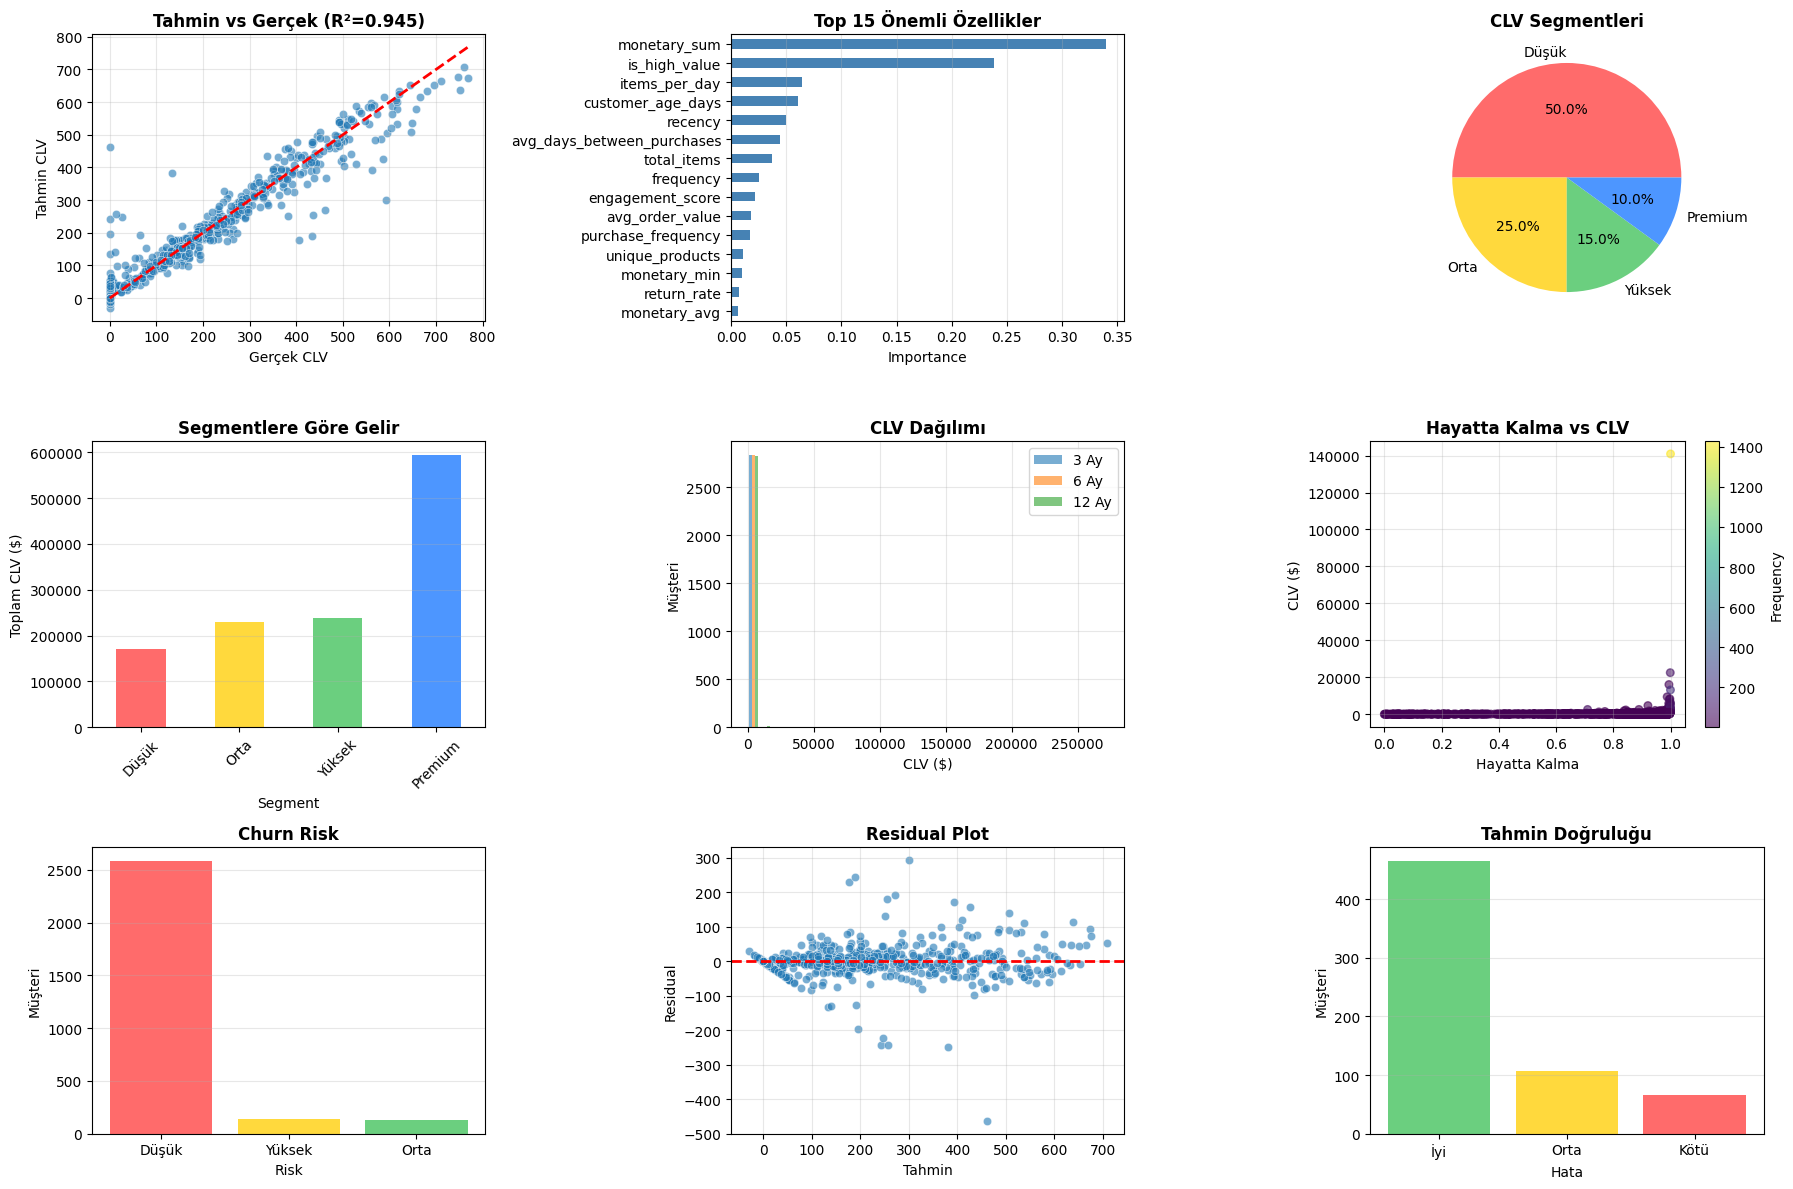


📋 ÖZET RAPOR

💰 GELİR POTANSİYELİ:
   • Toplam 6 Aylık CLV: $1,233,168.91
   • Premium Gelir: $594,888.43 (%48.2)

⚠️  RİSK:
   • Churn Riski: 136 müşteri
   • Risk Altındaki Gelir: $3,282.21

🎯 AKSİYON:
   1. Premium VIP: 285 müşteri
   2. Win-back: 68 müşteri
   3. Cross-sell: 295 müşteri

🤖 MODEL:
   • R² Score: 0.9450
   • Doğruluk: %56.7
   • Güvenilirlik: Yüksek

✅ Tam analiz tamamlandı!


In [14]:

# ==========================================
# BÖLÜM 4: İŞ DEĞERİ ANALİZİ
# ==========================================
print("\n\n" + "="*80)
print("💼 BÖLÜM 4: İŞ DEĞERİ VE AKSIYON ÖNERİLERİ")
print("="*80)

# CLV Özeti
print("\n📈 CLV İSTATİSTİKLERİ:")
print(f"   Toplam Müşteri: {len(rfm):,}")
print(f"   Ortalama 6 Aylık CLV: ${rfm['clv_6m'].mean():,.2f}")
print(f"   Toplam Tahmini Gelir (6 ay): ${rfm['clv_6m'].sum():,.2f}")
print(f"   Ortalama Hayatta Kalma: %{rfm['prob_alive'].mean()*100:.1f}")

# Segmentasyon
clv_percentiles = rfm['clv_6m'].quantile([0.5, 0.75, 0.90])
rfm['clv_segment'] = pd.cut(
    rfm['clv_6m'],
    bins=[-np.inf, clv_percentiles[0.5], clv_percentiles[0.75], clv_percentiles[0.90], np.inf],
    labels=['Düşük', 'Orta', 'Yüksek', 'Premium']
)

segment_analysis = rfm.groupby('clv_segment').agg({
    'CustomerID': 'count',
    'clv_6m': 'sum',
    'monetary_avg': 'mean',
    'frequency': 'mean',
    'prob_alive': 'mean'
}).round(2)
segment_analysis.columns = ['Müşteri Sayısı', 'Toplam CLV', 'Ort. İşlem', 'Ort. Sıklık', 'Hayatta Kalma']
segment_analysis['Gelir %'] = (segment_analysis['Toplam CLV'] / segment_analysis['Toplam CLV'].sum() * 100).round(1)

print("\n🎯 MÜŞTERİ SEGMENTLERİ:")
print(segment_analysis)

# Churn Risk
churn_risk = rfm[rfm['prob_alive'] < 0.3].copy()
print(f"\n⚠️  CHURN RİSKİ:")
print(f"   Yüksek Risk: {len(churn_risk)} müşteri")
print(f"   Risk Altındaki Gelir: ${churn_risk['clv_6m'].sum():,.2f}")

# Aksiyon grupları
premium = rfm[rfm['clv_segment'] == 'Premium']
high_potential = rfm[(rfm['monetary_avg'] > rfm['monetary_avg'].quantile(0.75)) &
                     (rfm['frequency'] < rfm['frequency'].quantile(0.5))]
valuable_at_risk = churn_risk[churn_risk['clv_6m'] > churn_risk['clv_6m'].median()]

print(f"\n💡 AKSİYON ÖNCELİKLERİ:")
print(f"   1. Premium müşteriler: {len(premium)} kişi → VIP program")
print(f"   2. Yüksek potansiyel: {len(high_potential)} kişi → Cross-sell")
print(f"   3. Değerli ama riskli: {len(valuable_at_risk)} kişi → Win-back")

# ML Tahmin Analizi
test_results = pd.DataFrame({
    'Gerçek_CLV': y_test.values,
    'Tahmin_CLV': y_pred_test,
    'Hata_Yüzde': np.abs(y_test.values - y_pred_test) / (y_test.values + 1) * 100
})

accurate = (test_results['Hata_Yüzde'] < 20).sum()
print(f"\n🤖 ML MODEL DOĞRULUĞU:")
print(f"   İyi Tahmin (<20% hata): {accurate} müşteri (%{accurate/len(test_results)*100:.1f})")

# ==========================================
# BÖLÜM 5: GÖRSELLEŞTİRMELER
# ==========================================
print("\n📊 Görselleştirmeler oluşturuluyor...")

fig = plt.figure(figsize=(18, 12))

# 1. Tahmin vs Gerçek
ax1 = plt.subplot(3, 3, 1)
sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Gerçek CLV")
plt.ylabel("Tahmin CLV")
plt.title(f"Tahmin vs Gerçek (R²={test_r2:.3f})", fontweight='bold')
plt.grid(alpha=0.3)

# 2. Feature Importance
ax2 = plt.subplot(3, 3, 2)
feat_imp = pd.Series(xgb_model.feature_importances_, index=X.columns).nlargest(15)
feat_imp.sort_values().plot(kind='barh', color='steelblue')
plt.xlabel("Importance")
plt.title("Top 15 Önemli Özellikler", fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# 3. CLV Segmentleri
ax3 = plt.subplot(3, 3, 3)
segment_counts = rfm['clv_segment'].value_counts()
colors = ['#ff6b6b', '#ffd93d', '#6bcf7f', '#4d96ff']
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', colors=colors)
plt.title('CLV Segmentleri', fontweight='bold')

# 4. Gelir Katkısı
ax4 = plt.subplot(3, 3, 4)
segment_analysis['Toplam CLV'].plot(kind='bar', color=colors)
plt.xlabel('Segment')
plt.ylabel('Toplam CLV ($)')
plt.title('Segmentlere Göre Gelir', fontweight='bold')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# 5. CLV Dağılımı
ax5 = plt.subplot(3, 3, 5)
plt.hist([rfm['clv_3m'], rfm['clv_6m'], rfm['clv_12m']], bins=30, alpha=0.6,
         label=['3 Ay', '6 Ay', '12 Ay'])
plt.xlabel('CLV ($)')
plt.ylabel('Müşteri')
plt.title('CLV Dağılımı', fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# 6. Hayatta Kalma vs CLV
ax6 = plt.subplot(3, 3, 6)
scatter = plt.scatter(rfm['prob_alive'], rfm['clv_6m'], c=rfm['frequency'],
                     cmap='viridis', alpha=0.6, s=30)
plt.colorbar(scatter, label='Frequency')
plt.xlabel('Hayatta Kalma')
plt.ylabel('CLV ($)')
plt.title('Hayatta Kalma vs CLV', fontweight='bold')
plt.grid(alpha=0.3)

# 7. Churn Risk
ax7 = plt.subplot(3, 3, 7)
risk_segments = pd.cut(rfm['prob_alive'], bins=[0, 0.3, 0.6, 1.0],
                       labels=['Yüksek', 'Orta', 'Düşük'])
risk_counts = risk_segments.value_counts()
plt.bar(risk_counts.index, risk_counts.values, color=['#ff6b6b', '#ffd93d', '#6bcf7f'])
plt.xlabel('Risk')
plt.ylabel('Müşteri')
plt.title('Churn Risk', fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# 8. Residual Plot
ax8 = plt.subplot(3, 3, 8)
residuals = y_test - y_pred_test
sns.scatterplot(x=y_pred_test, y=residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Tahmin')
plt.ylabel('Residual')
plt.title('Residual Plot', fontweight='bold')
plt.grid(alpha=0.3)

# 9. Model Doğruluk
ax9 = plt.subplot(3, 3, 9)
error_cat = pd.cut(test_results['Hata_Yüzde'], bins=[0, 20, 50, 100],
                   labels=['İyi', 'Orta', 'Kötü'])
error_counts = error_cat.value_counts()
plt.bar(error_counts.index, error_counts.values, color=['#6bcf7f', '#ffd93d', '#ff6b6b'])
plt.xlabel('Hata')
plt.ylabel('Müşteri')
plt.title('Tahmin Doğruluğu', fontweight='bold')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ==========================================
# ÖZET RAPOR
# ==========================================
print("\n" + "="*80)
print("📋 ÖZET RAPOR")
print("="*80)
print(f"""
💰 GELİR POTANSİYELİ:
   • Toplam 6 Aylık CLV: ${rfm['clv_6m'].sum():,.2f}
   • Premium Gelir: ${premium['clv_6m'].sum():,.2f} (%{premium['clv_6m'].sum()/rfm['clv_6m'].sum()*100:.1f})

⚠️  RİSK:
   • Churn Riski: {len(churn_risk)} müşteri
   • Risk Altındaki Gelir: ${valuable_at_risk['clv_6m'].sum():,.2f}

🎯 AKSİYON:
   1. Premium VIP: {len(premium)} müşteri
   2. Win-back: {len(valuable_at_risk)} müşteri
   3. Cross-sell: {len(high_potential)} müşteri

🤖 MODEL:
   • R² Score: {test_r2:.4f}
   • Doğruluk: %{accurate/len(test_results)*100:.1f}
   • Güvenilirlik: {'Yüksek' if test_r2 > 0.7 else 'Orta'}
""")
print("="*80)
print("✅ Tam analiz tamamlandı!")
print("="*80)